In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path("daily_csv")

FOMC_announcement = [
    "2012-01-25","2012-03-13","2012-04-25","2012-06-20","2012-08-01","2012-09-13","2012-10-24","2012-12-12",
    "2013-01-30","2013-03-20","2013-05-01","2013-06-19","2013-07-31","2013-09-18","2013-10-30","2013-12-18",
    "2014-01-29","2014-03-19","2014-04-30","2014-06-18","2014-07-30","2014-09-17","2014-10-29","2014-12-17",
    "2015-01-28","2015-03-18","2015-04-29","2015-06-17","2015-07-29","2015-09-17","2015-10-28","2015-12-16",
    "2016-01-27","2016-03-16","2016-04-27","2016-06-15","2016-07-27","2016-09-21","2016-11-02","2016-12-14",
    "2017-02-01","2017-03-15","2017-05-03","2017-06-14","2017-07-26","2017-09-20","2017-11-01","2017-12-13",
    "2018-01-31","2018-03-21","2018-05-02","2018-06-13","2018-08-01","2018-09-26","2018-11-08","2018-12-19",
    "2019-01-30","2019-03-20","2019-05-01","2019-06-19","2019-07-31","2019-09-18","2019-10-30","2019-12-11",
    "2020-01-29","2020-04-29","2020-06-10","2020-07-29","2020-09-16","2020-11-05","2020-12-16",
    "2021-01-27","2021-03-17","2021-04-28","2021-06-16","2021-07-28","2021-09-22","2021-11-03","2021-12-15",
    "2022-01-26","2022-03-16","2022-05-04","2022-06-15","2022-07-27","2022-09-21","2022-11-02","2022-12-14",
]
trading_halt = [
    '2013-07-03','2013-11-29','2013-12-24',
    '2014-07-03','2014-10-30','2014-11-28','2014-12-24',
    '2015-11-27','2015-12-24',
    '2016-11-25',
    '2017-07-03','2017-11-24',
    '2018-07-03','2018-11-23','2018-12-24',
    "2019-07-03","2019-08-12","2019-11-29","2019-12-24",
    "2020-03-09","2020-03-12","2020-03-16","2020-03-18","2020-11-27","2020-12-24",
    "2021-05-05","2022-11-26","2022-11-25"
]
EXCLUDE = set(pd.to_datetime(FOMC_announcement + trading_halt))

def _read_one(path: Path) -> pd.DataFrame | None:
    if path.suffix.lower() == ".icloud":
        print(f"⏭️  Skipping placeholder: {path.name}")
        return None
    try:
        df = pd.read_csv(path, usecols=["DT", "Price"])
        # Parse & clean
        df["DT"] = pd.to_datetime(df["DT"], errors="coerce")
        df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
        df = df.dropna(subset=["DT", "Price"])
        return df
    except Exception as e:
        print(f"⚠️  Skipping {path.name}: {e}")
        return None

def load_concat(data_dir: Path) -> pd.DataFrame:
    files = sorted(p for p in data_dir.glob("spy_*.csv*") if p.is_file())
    parts = [x for p in files if (x := _read_one(p)) is not None and not x.empty]
    if not parts:
        raise RuntimeError("No readable CSVs found in the folder.")
    df = pd.concat(parts, ignore_index=True)

    # Drop excluded calendar days (normalize DT to midnight)
    dnorm = df["DT"].dt.normalize()
    df = df[~dnorm.isin(EXCLUDE)]

    # Sort & deduplicate by timestamp
    df = df.sort_values("DT").drop_duplicates(subset="DT", keep="last").reset_index(drop=True)
    return df

df = load_concat(DATA_DIR)
print(f"Rows: {len(df):,} | from {df['DT'].min()} to {df['DT'].max()}")

# Save a single clean file next to the folder
out_path = DATA_DIR.parent / "spy_all.csv"
df.to_csv(out_path, index=False)
print(f"Saved: {out_path}")


Rows: 22,581,000 | from 2019-01-02 09:30:01 to 2022-12-30 16:00:00
Saved: spy_all.csv


In [ ]:

from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import math

DAILY_DIR: Optional[Path] = Path("daily_csv")  # or None

PATH_CSV_ALL: Path = Path("spy_all.csv")

MERGED_OUT: Path = PATH_CSV_ALL  # change if you want a different filename

# Monte Carlo runs
N_MC = 200
SEED = 123

EXCLUDE_DATES = set(pd.to_datetime(FOMC_announcement + trading_halt))

# -------------------- Intraday window (RTH) -------------------
RTH_OPEN = (9, 30)    # 09:30
RTH_CLOSE = (16, 0)   # 16:00

def realized_variance_from_returns(r: np.ndarray, k: int) -> np.ndarray:
    """Rolling sum of squared returns over k steps."""
    sq = r * r
    return np.convolve(sq, np.ones(k, float), mode="valid")

def autocovariances(x: np.ndarray, lags: List[int]) -> Dict[int, float]:
    xc = x - x.mean()
    n = len(xc)
    return {ell: float(np.dot(xc[:n-ell], xc[ell:]) / n) for ell in lags if ell < n}

def estimate_H_from_autocov(gammas: Dict[int, float]) -> Tuple[float, float]:
    """Power-law fit: gamma(ell) ≈ C * ell^alpha ⇒ H = 1 + alpha/2."""
    items = [(ell, g) for ell, g in gammas.items() if g > 0]
    if len(items) < 2:
        return np.nan, np.nan
    l = np.array([i[0] for i in items], float)
    g = np.array([i[1] for i in items], float)
    X = np.vstack([np.ones_like(l), np.log(l)]).T
    beta, *_ = np.linalg.lstsq(X, np.log(g), rcond=None)
    alpha = beta[1]
    # SE via OLS delta method
    pred = X @ beta
    resid = np.log(g) - pred
    dof = max(len(g) - 2, 1)
    s2 = (resid @ resid) / dof
    cov_beta = s2 * np.linalg.inv(X.T @ X)
    se_H = 0.5 * np.sqrt(cov_beta[1,1])
    return 1 + 0.5 * alpha, se_H

def concat_daily_csvs(data_dir: Path, out_path: Path) -> Path:
    """Concatenate spy_*.csv* files with columns DT,Price. Skips iCloud placeholders."""
    files = sorted([p for p in data_dir.glob("spy_*.csv*") if p.is_file()])
    if not files:
        raise RuntimeError(f"No files like 'spy_*.csv*' found in {data_dir}")
    parts = []
    for p in files:
        if p.suffix.lower() == ".icloud":
            print(f"⏭️  Skipping placeholder: {p.name}")
            continue
        try:
            df = pd.read_csv(p, usecols=["DT","Price"])
            df["DT"] = pd.to_datetime(df["DT"], errors="coerce")
            df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
            df = df.dropna(subset=["DT","Price"])
            if not df.empty:
                parts.append(df)
        except Exception as e:
            print(f"Skipping {p.name}: {e}")
    if not parts:
        raise RuntimeError("No readable CSVs after filtering placeholders/errors.")
    df_all = pd.concat(parts, ignore_index=True)
    # Sort, deduplicate by timestamp
    df_all = df_all.sort_values("DT").drop_duplicates(subset="DT", keep="last").reset_index(drop=True)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df_all.to_csv(out_path, index=False)
    print(f"[concat] Saved merged file with {len(df_all):,} rows → {out_path}")
    return out_path

def _align_one_df(df_in: pd.DataFrame, dt_sec: int, verbose: bool) -> Optional[pd.DataFrame]:
    """Align a naive-ET dataframe to a strict RTH grid at dt_sec."""
    df = df_in.dropna(subset=["DT", "Price"]).copy()
    df = df.sort_values("DT")
    df["date"] = df["DT"].dt.date

    n_kept, n_skipped = 0, 0
    out = []
    for d, g in df.groupby("date", sort=True):
        if pd.Timestamp(d).normalize() in EXCLUDE_DATES:
            continue
        day = pd.Timestamp(d)
        start = day.replace(hour=RTH_OPEN[0], minute=RTH_OPEN[1], second=0)
        end   = day.replace(hour=RTH_CLOSE[0], minute=RTH_CLOSE[1], second=0)

        gi = g.set_index("DT").sort_index()
        # 2-min buffer before open to help ffill the head
        gi_buf = gi.loc[(gi.index >= start - pd.Timedelta("2min")) & (gi.index <= end)]
        if gi_buf.empty:
            n_skipped += 1
            continue

        grid = pd.date_range(start, end, freq=f"{dt_sec}S")
        gi2 = gi_buf.reindex(grid)
        gi2["Price"] = gi2["Price"].ffill().bfill()
        # keep only if there was at least one *real* obs in RTH
        if gi.loc[(gi.index >= start) & (gi.index <= end)].empty:
            n_skipped += 1
            continue

        gi2 = gi2.rename_axis("DT").reset_index()
        gi2["date"] = d
        out.append(gi2[["DT", "date", "Price"]])
        n_kept += 1

    if verbose:
        print(f"[align] dt={dt_sec}s → kept days: {n_kept} | skipped: {n_skipped}")
    if not out:
        return None
    return pd.concat(out, ignore_index=True)

def load_and_align(path_csv: Path, dt_sec: int, verbose: bool=True) -> Optional[pd.DataFrame]:
    """Try naive ET; if empty, try UTC→NY conversion."""
    raw = pd.read_csv(path_csv, parse_dates=["DT"]).dropna(subset=["DT","Price"])

    aligned = _align_one_df(raw, dt_sec, verbose)
    if aligned is not None and not aligned.empty:
        return aligned

    raw2 = raw.copy()
    dt_parsed = pd.to_datetime(raw2["DT"], utc=True, errors="coerce")
    raw2["DT"] = dt_parsed.dt.tz_convert("America/New_York").dt.tz_localize(None)
    aligned2 = _align_one_df(raw2, dt_sec, verbose)
    if aligned2 is not None and not aligned2.empty:
        print("[align] Interpreted timestamps as UTC and converted to New York.")
        return aligned2

    return None

def choose_dt_and_align(path_csv: Path, verbose: bool=True) -> Tuple[pd.DataFrame, int]:
    """Try 5s; if not feasible, fall back to 60s."""
    for cand in (5, 60):
        aligned = load_and_align(path_csv, cand, verbose=verbose)
        if aligned is not None and not aligned.empty:
            if verbose:
                print(f"[align] Using dt_sec={cand}.")
            return aligned, cand
    raise RuntimeError(
        "No usable RTH days found at 5s or 60s. Check timezone/frequency or data coverage."
    )

def to_daily_returns(aligned: pd.DataFrame) -> List[np.ndarray]:
    """Extract same-length daily log-return arrays; keep the modal length."""
    rets = []
    for d, g in aligned.groupby("date", sort=True):
        p = g["Price"].to_numpy()
        r = np.diff(np.log(p))
        rets.append(r)
    # guardrail: enforce consistent daily length
    counts = pd.Series([len(x) for x in rets])
    mode_len = int(counts.mode().iloc[0])
    rets = [r for r in rets if len(r) == mode_len]
    if len(rets) == 0:
        raise RuntimeError("All days had inconsistent lengths after alignment.")
    return rets

# ==================== Heston calibration =====================
@dataclass
class HestonParams:
    kappa: float
    theta: float
    xi: float
    rho: float
    v0: float
    s0: float

def calibrate_heston_from_returns(all_rets: List[np.ndarray], dt_years: float, s0: float) -> HestonParams:
    """Fast moment-matching calibration from high-frequency returns."""
    r = np.concatenate(all_rets)            # shape [N_total]
    v = (r**2) / dt_years                   # variance proxy

    v_t, v_tp = v[:-1], v[1:]
    X = np.vstack([np.ones_like(v_t), v_t]).T
    beta, *_ = np.linalg.lstsq(X, v_tp, rcond=None)
    c, phi = float(beta[0]), float(beta[1])
    phi = min(max(phi, -0.99), 0.999999)

    kappa = max((1 - phi) / dt_years, 1e-8)
    theta = max(c / (1 - phi), 1e-12)

    e = v_tp - (c + phi * v_t)
    denom = np.sum(v_t * dt_years)
    xi2 = np.sum(e**2) / max(denom, 1e-16)
    xi = float(np.sqrt(max(xi2, 1e-16)))

    vt_dt = np.maximum(v_t * dt_years, 1e-16)
    eta = (r[1:] + 0.5 * v_t * dt_years) / np.sqrt(vt_dt)
    zeta = e / (xi * np.sqrt(vt_dt))
    rho = float(np.corrcoef(eta, zeta)[0,1])
    rho = float(np.clip(rho, -0.999, 0.999))

    return HestonParams(kappa=kappa, theta=theta, xi=xi, rho=rho, v0=float(theta), s0=float(s0))

# ===================== Heston QE simulator ===================
def heston_qe_step(s, v, dt, p: HestonParams, z1, z2):
    z_v = z1
    z_s = p.rho * z1 + np.sqrt(1 - p.rho**2) * z2

    m = p.theta + (v - p.theta) * np.exp(-p.kappa * dt)
    s2 = (v * p.xi**2 * np.exp(-p.kappa * dt) / p.kappa) * (1 - np.exp(-p.kappa * dt)) \
         + (p.theta * p.xi**2 / (2*p.kappa)) * (1 - np.exp(-p.kappa * dt))**2
    psi = s2 / (m**2 + 1e-16)

    if psi <= 1.5:
        b2 = 2/psi - 1 + np.sqrt(2/psi) * np.sqrt(2/psi - 1)
        a = m / (1 + b2)
        v_next = a * (np.sqrt(b2) * z_v + 1)**2
    else:
        p_qe = (psi - 1) / (psi + 1)
        beta = (1 - p_qe) / m
        U = 0.5 * (1 + math.erf(z_v / np.sqrt(2)))
        v_next = 0.0 if U <= p_qe else -np.log((1 - p_qe) / (1 - U)) / beta

    v_bar = max(0.5 * (v + v_next), 0.0)
    s_next = s * np.exp(-0.5 * v_bar * dt + np.sqrt(max(v_bar, 0.0) * dt) * z_s)
    return s_next, max(v_next, 0.0)

def simulate_heston_day(p: HestonParams, dt_years: float, steps: int, rng: np.random.Generator):
    s = np.empty(steps+1); v = np.empty(steps+1)
    s[0], v[0] = p.s0, p.v0
    z = rng.standard_normal(size=(2, steps))
    for i in range(steps):
        s[i+1], v[i+1] = heston_qe_step(s[i], v[i], dt_years, p, z[0,i], z[1,i])
    return s, v

# ================= Estimation on returns (RV ACF) ====================
def estimate_H_on_returns(day_rets: List[np.ndarray]) -> Dict[str, object]:
    k10, k15 = 120, 150
    l10 = [1,2,3,4,5,6]
    l15 = [1,2,3,4]
    ac10 = {ell:0.0 for ell in l10}
    ac15 = {ell:0.0 for ell in l15}
    n = 0
    for r in day_rets:
        rv10 = realized_variance_from_returns(r, k10)
        rv15 = realized_variance_from_returns(r, k15)
        a10 = autocovariances(rv10, l10)
        a15 = autocovariances(rv15, l15)
        for ell in l10: ac10[ell] += a10[ell]
        for ell in l15: ac15[ell] += a15[ell]
        n += 1
    ac10 = {k:v/n for k,v in ac10.items()}
    ac15 = {k:v/n for k,v in ac15.items()}
    pooled = {}
    pooled.update(ac10)
    for ell,g in ac15.items():
        pooled[ell] = pooled.get(ell, 0.0) + g
    H, seH = estimate_H_from_autocov(pooled)
    return {"ac10": ac10, "ac15": ac15, "H": H, "H_se": seH, "days": n}

# ====================== Monte Carlo driver ===========================
def run_mc_from_data(aligned_df: pd.DataFrame, dt_sec: int, n_mc: int = 200, seed: int = 123):
    steps_per_day = int(6.5*3600 // dt_sec)
    dt_years = dt_sec / (252 * 6.5 * 3600)

    day_rets = to_daily_returns(aligned_df)
    real_est = estimate_H_on_returns(day_rets)

    first_day = min(aligned_df["date"])
    s0 = float(aligned_df.loc[aligned_df["date"] == first_day, "Price"].iloc[0])
    params = calibrate_heston_from_returns(day_rets, dt_years, s0)

    rng = np.random.default_rng(seed)
    H_list = []
    for _ in range(n_mc):
        mc_rets = []
        p_today = params
        for _day in range(len(day_rets)):
            s_path, v_path = simulate_heston_day(p_today, dt_years, steps_per_day, rng)
            r = np.diff(np.log(s_path))
            mc_rets.append(r)
            # roll end-of-day state forward
            p_today = HestonParams(
                kappa=params.kappa, theta=params.theta, xi=params.xi, rho=params.rho,
                v0=float(v_path[-1]), s0=float(s_path[-1])
            )
        est = estimate_H_on_returns(mc_rets)
        H_list.append(est["H"])

    H_arr = np.array(H_list, dtype=float)
    return {
        "empirical_H": float(real_est["H"]),
        "empirical_H_se": float(real_est["H_se"]),
        "days_used": int(real_est["days"]),
        "ac10_empirical": real_est["ac10"],
        "ac15_empirical": real_est["ac15"],
        "calibrated_params": params.__dict__,
        "dt_sec": dt_sec,
        "mc_runs": int(n_mc),
        "H_mc_mean": float(np.nanmean(H_arr)),
        "H_mc_std": float(np.nanstd(H_arr, ddof=1)),
        "H_mc_p5": float(np.nanpercentile(H_arr, 5)),
        "H_mc_p95": float(np.nanpercentile(H_arr, 95)),
    }

if __name__ == "__main__":
    if DAILY_DIR is not None:
        PATH_CSV_ALL = concat_daily_csvs(DAILY_DIR, MERGED_OUT)

    aligned, dt_sec = choose_dt_and_align(PATH_CSV_ALL, verbose=True)

    summary = run_mc_from_data(aligned, dt_sec=dt_sec, n_mc=N_MC, seed=SEED)

    print("\n========== EMPIRICAL ==========")
    print(f"Grid: {summary['dt_sec']} seconds | Days used: {summary['days_used']}")
    print(f"H (empirical): {summary['empirical_H']:.3f}  (SE ≈ {summary['empirical_H_se']:.3f})")

    print("\n===== CALIBRATED HESTON (no jumps/noise) =====")
    for k, v in summary["calibrated_params"].items():
        if isinstance(v, float):
            print(f"  {k:6s}: {v:.6g}")
        else:
            print(f"  {k:6s}: {v}")

    print("\n========== MONTE CARLO ==========")
    print(f"Runs: {summary['mc_runs']}  |  H_mean={summary['H_mc_mean']:.3f}  "
          f"H_sd={summary['H_mc_std']:.3f}  "
          f"[p5, p95]=[{summary['H_mc_p5']:.3f}, {summary['H_mc_p95']:.3f}]")


[concat] Saved merged file with 23,587,200 rows → spy_all.csv


/var/folders/4w/x8plpw_x0pb6wcfdl87b6lxc0000gp/T/ipykernel_3406/2690492950.py:143: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  grid = pd.date_range(start, end, freq=f"{dt_sec}S")
/var/folders/4w/x8plpw_x0pb6wcfdl87b6lxc0000gp/T/ipykernel_3406/2690492950.py:143: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  grid = pd.date_range(start, end, freq=f"{dt_sec}S")
/var/folders/4w/x8plpw_x0pb6wcfdl87b6lxc0000gp/T/ipykernel_3406/2690492950.py:143: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  grid = pd.date_range(start, end, freq=f"{dt_sec}S")
/var/folders/4w/x8plpw_x0pb6wcfdl87b6lxc0000gp/T/ipykernel_3406/2690492950.py:143: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  grid = pd.date_range(start, end, freq=f"{dt_sec}S")
/var/folders/4w/x8plpw_x0pb6wcfdl87b6lxc0000gp/T/ipykernel_3

[align] dt=5s → kept days: 965 | skipped: 0
[align] Using dt_sec=5.

========== EMPIRICAL ==========
Grid: 5 seconds | Days used: 965
H (empirical): 0.759  (SE ≈ 0.119)

===== CALIBRATED HESTON (no jumps/noise) =====
  kappa : 915200
  theta : 0.0244958
  xi    : 970.658
  rho   : -0.0238348
  v0    : 0.0244958
  s0    : 245.99

========== MONTE CARLO ==========
Runs: 200  |  H_mean=nan  H_sd=nan  [p5, p95]=[nan, nan]


/var/folders/4w/x8plpw_x0pb6wcfdl87b6lxc0000gp/T/ipykernel_3406/2690492950.py:346: RuntimeWarning: Mean of empty slice
  "H_mc_mean": float(np.nanmean(H_arr)),
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


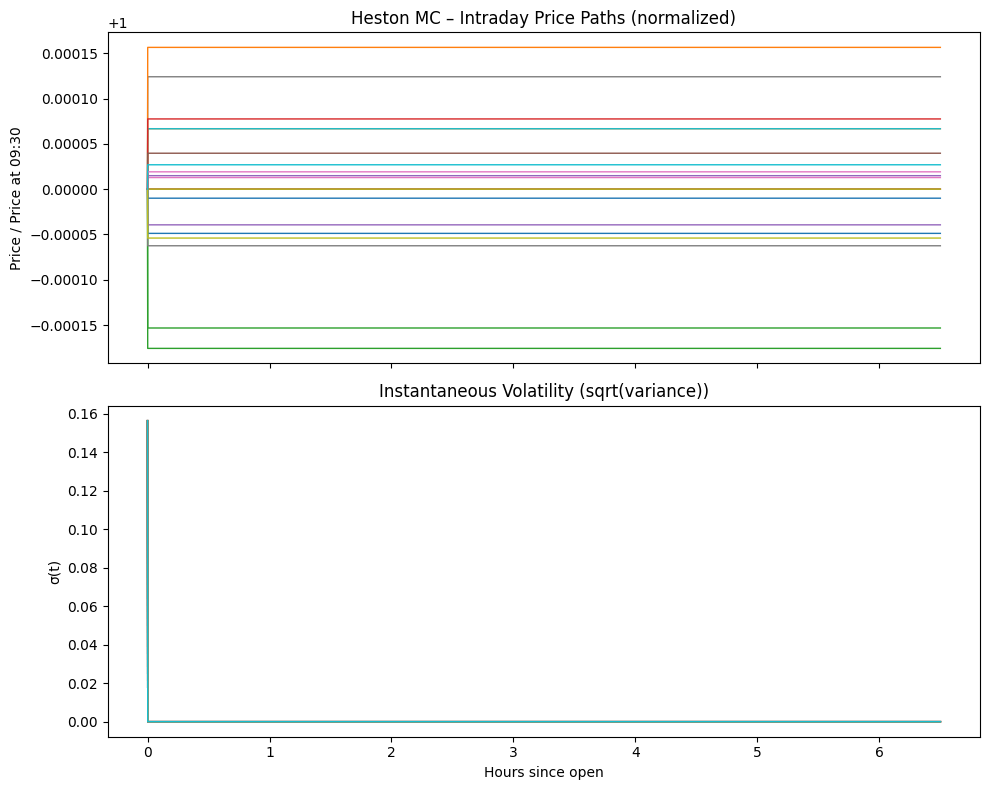

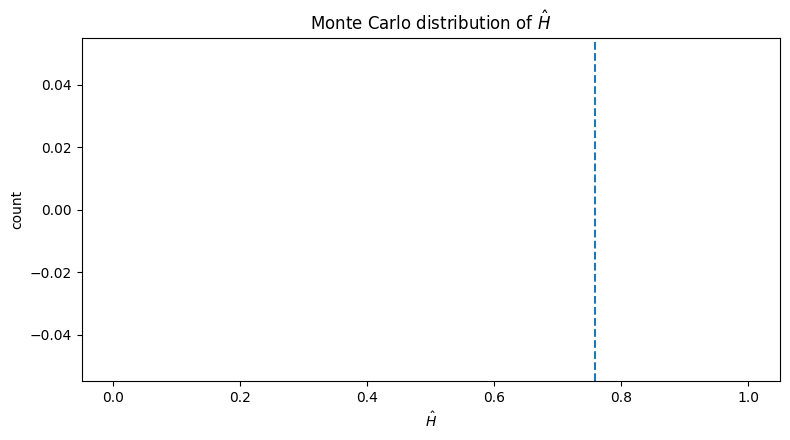

In [ ]:

import math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

try:
    HestonParams  
except NameError:
    @dataclass
    class HestonParams:
        kappa: float
        theta: float
        xi: float
        rho: float
        v0: float
        s0: float

def _simulate_heston_day(p: HestonParams, dt_years: float, steps: int, rng: np.random.Generator):
    s = np.empty(steps+1); v = np.empty(steps+1)
    s[0], v[0] = p.s0, p.v0
    z = rng.standard_normal(size=(2, steps))
    for i in range(steps):
        s[i+1], v[i+1] = heston_qe_step(s[i], v[i], dt_years, p, z[0, i], z[1, i])
    return s, v

try:
    p_dict = summary["calibrated_params"]  # from earlier code cell
    dt_sec = int(summary["dt_sec"])
    p = HestonParams(**{k: p_dict[k] for k in ["kappa","theta","xi","rho","v0","s0"]})
except Exception:
    dt_sec = 5
    p = HestonParams(kappa=3.0, theta=0.04, xi=0.5, rho=-0.7, v0=0.04, s0=100.0)

steps_per_day = int(6.5*3600 // dt_sec)
dt_years = dt_sec / (252 * 6.5 * 3600)

rng = np.random.default_rng(123)
n_plot_paths = 20
S_paths = []
V_paths = []
for _ in range(n_plot_paths):
    s_path, v_path = _simulate_heston_day(p, dt_years, steps_per_day, rng)
    S_paths.append(s_path)
    V_paths.append(v_path)

t_hours = np.arange(steps_per_day+1) * (dt_sec/3600.0)

fig1, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# Prices, normalized to 1 at the open
for s in S_paths:
    axs[0].plot(t_hours, s / s[0], linewidth=1)
axs[0].set_title("Heston MC – Intraday Price Paths (normalized)")
axs[0].set_ylabel("Price / Price at 09:30")

# Variance (instantaneous), annualized volatility sqrt(v)
for v in V_paths:
    axs[1].plot(t_hours, np.sqrt(np.maximum(v, 0.0)), linewidth=1)
axs[1].set_title("Instantaneous Volatility (sqrt(variance))")
axs[1].set_xlabel("Hours since open")
axs[1].set_ylabel("σ(t)")

plt.tight_layout()
plt.show()

try:
    n_days = len(to_daily_returns(aligned)) if "aligned" in globals() else 20
    n_mc = 200
    H_list = []
    for m in range(n_mc):
        mc_rets = []
        p_today = p
        for _ in range(n_days):
            s_path, v_path = _simulate_heston_day(p_today, dt_years, steps_per_day, rng)
            r = np.diff(np.log(s_path))
            mc_rets.append(r)
            # roll the end-of-day state forward
            p_today = HestonParams(
                kappa=p.kappa, theta=p.theta, xi=p.xi, rho=p.rho,
                v0=float(v_path[-1]), s0=float(s_path[-1])
            )
        # Estimate H on these simulated days
        est = estimate_H_on_returns(mc_rets)  # from your earlier code cell
        H_list.append(est["H"])

    fig2, ax = plt.subplots(figsize=(8, 4.5))
    ax.hist([h for h in H_list if np.isfinite(h)], bins=20, alpha=0.85)
    ax.set_title("Monte Carlo distribution of $\hat{H}$")
    ax.set_xlabel("$\hat{H}$")
    ax.set_ylabel("count")

    try:
        ax.axvline(summary["empirical_H"], linestyle="--")
    except Exception:
        pass

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"(Skipped H-histogram; missing helpers like estimate_H_on_returns or aligned. Reason: {e})")
